<a href="https://colab.research.google.com/github/ykkimhgu/DLIP-src/blob/main/Tutorial_Pytorch/Assignment_PyTorch_T3_3_Transfer_Learning_using_Pre_trained_Models_(classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DLIP Tutorial - PyTorch**
# Transfer Learning using Pre-trained Models (Classification) - Assignment

J.-J. Lee
(updated 2025. 5. 16) 

===================

Create a CNN model 'EfficientNet(efficientnet_b7)' and Train with Custom Dataset

## For CoLab Usage:

1. Download this notebook
2. Then, open in Colab

# Environment Setup

Download Python modules and image data. 
- [download modules](https://drive.google.com/file/d/1hjrWkcvBTiI-5yGtWPvsYVdaE7YLNWDo/view?usp=sharing)
- [download dataset(cat/dog)](https://drive.google.com/file/d/1KYOAxXDIqp_hhE97WWQ_C8TeGFHWkxqG/view?usp=sharingg)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# from set_parameter_requires_grad import set_parameter_requires_grad
import sys
import os

# 정확한 경로 지정
# model_path = r"C:\Users\User\source\repos\DLIP\Tutorial\TU_model"
# sys.path.append(model_path)
# from set_parameter_requires_grad import set_parameter_requires_grad
from initialize_model_module import initialize_model
from train_module import train
from test_module import test
# from initialize_model import initialize_model
# from train import train
# from test import test

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'Device name: {torch.cuda.get_device_name(0)}') 


Using cuda device
Device name: NVIDIA GeForce RTX 4080 Laptop GPU


# MODEL

Basically, the classification models provided by torchvision are trained on ImageNet and consist of 1000 output layers.

However, in the model for fine-tuning with other datasets, the number of output layers should be different depending on the class.

Here, we use the initialize_model() function provided in the [pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) to change the output stage of the model.

initialize_model() is a function that helps to initialize the fine-tuning of some models.

If the model is not in the function, the output layer information can be known by printing the model with the print() function.

In [50]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception*]
model_name = "efficientnet_b7"

# Number of classes in the dataset
num_classes = 2

feature_extract = True   # True: only update the reshaped layer params, False: finetune the whole model, 

####################################################################
### add your code for 'efficientnet_b7' in 'initialize_model.py' ###
####################################################################

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)  
model_ft = model_ft.to(device)

from torchsummary import summary
summary(model_ft, (3,input_size,input_size))

c:\Users\User\anaconda\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,728
       BatchNorm2d-2         [-1, 64, 300, 300]             128
              SiLU-3         [-1, 64, 300, 300]               0
            Conv2d-4         [-1, 64, 300, 300]             576
       BatchNorm2d-5         [-1, 64, 300, 300]             128
              SiLU-6         [-1, 64, 300, 300]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12         [-1, 64, 300, 300]               0
           Conv2d-13         [-1, 32, 300, 300]           2,048
      BatchNorm2d-14         [-1, 32, 3

# Prepare Datasets: kaggle cats and dogs

**TO DO**

download the kaggle cats and dogs dataset: [download link](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

In [ ]:
### ADD YOUR CODE HERE
import shutil
import os
shutil.unpack_archive("data/PetImages.zip", "data")

The images in the prepared dataset have different sizes. In order to be used as a learning model, the following process is required. (refer to part2)

- Assign the images in the folder to training/test data for learning
- Same pre-processing as ImageNet data for input of learning model

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
from torch.utils.data import random_split
from torchvision import datasets, transforms
input_size = 600  
### ADD YOUR CODE HERE

# Data augmentation and normalization for training
# Just normalization for validation

### ADD YOUR CODE HERE
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./data/PetImages"

transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)

# train/val로 80:20 분할
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
training_data, test_data = random_split(full_dataset, [train_size, val_size])

classes = full_dataset.classes  # ['Cat', 'Dog']

print(f"train dataset length = {len(training_data)}")
print(f"test  dataset length = {len(test_data)}")

train dataset length = 19998
test  dataset length = 5000


Use DataLoader to make dataset iterable.

In [52]:
### ADD YOUR CODE HERE
# Batch size for training (change depending on how much memory you have)
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([8, 3, 600, 600]) torch.int64
Shape of y: torch.Size([8]) torch.int64


# Optimization Setup

### Optmizer function 
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available, 
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

### Loss function

- Linear regression->Mean Squared Error
- Classification->Cross entropy

In [53]:
### ADD YOUR CODE HERE
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9,weight_decay=5e-4)
optimizer = torch.optim.Adam(model_ft.parameters(), lr = 0.001, weight_decay=5e-4)

# Train and Test the model

In [ ]:
### ADD YOUR CODE HERE
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_ft, loss_fn, optimizer, device, 15)
    test(test_dataloader, model_ft, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 0.703491  [    0/19998]
loss: 0.380410  [  120/19998]
loss: 0.353885  [  240/19998]
loss: 0.185228  [  360/19998]
loss: 0.259133  [  480/19998]
loss: 0.239192  [  600/19998]
loss: 0.231880  [  720/19998]
loss: 0.391650  [  840/19998]
loss: 0.047850  [  960/19998]
loss: 0.018911  [ 1080/19998]
loss: 0.116048  [ 1200/19998]
loss: 0.024874  [ 1320/19998]
loss: 0.064775  [ 1440/19998]
loss: 0.199175  [ 1560/19998]
loss: 0.089803  [ 1680/19998]
loss: 0.373937  [ 1800/19998]
loss: 0.013707  [ 1920/19998]
loss: 0.081050  [ 2040/19998]
loss: 0.022997  [ 2160/19998]
loss: 0.063675  [ 2280/19998]
loss: 0.021086  [ 2400/19998]
loss: 0.040382  [ 2520/19998]
loss: 0.071079  [ 2640/19998]
loss: 0.041500  [ 2760/19998]
loss: 0.060186  [ 2880/19998]
loss: 0.204085  [ 3000/19998]
loss: 0.062851  [ 3120/19998]
loss: 0.024799  [ 3240/19998]
loss: 0.320479  [ 3360/19998]
loss: 0.077637  [ 3480/19998]
loss: 0.435344  [ 3600/19998]
loss: 0.003904  [ 3720/19998]


c:\Users\User\anaconda\envs\py39\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: 0.158846  [ 7200/19998]
loss: 0.014166  [ 7320/19998]
loss: 0.052452  [ 7440/19998]
loss: 0.009282  [ 7560/19998]
loss: 0.067853  [ 7680/19998]
loss: 0.043879  [ 7800/19998]
loss: 0.002843  [ 7920/19998]
loss: 0.032108  [ 8040/19998]
loss: 0.028735  [ 8160/19998]
loss: 0.037485  [ 8280/19998]
loss: 0.003441  [ 8400/19998]
loss: 0.010937  [ 8520/19998]
loss: 0.164476  [ 8640/19998]
loss: 0.029736  [ 8760/19998]
loss: 0.006484  [ 8880/19998]
loss: 0.090305  [ 9000/19998]
loss: 0.415754  [ 9120/19998]
loss: 0.015421  [ 9240/19998]
loss: 0.012819  [ 9360/19998]
loss: 0.144126  [ 9480/19998]
loss: 0.020327  [ 9600/19998]
loss: 0.047187  [ 9720/19998]
loss: 0.730783  [ 9840/19998]
loss: 0.951367  [ 9960/19998]
loss: 0.064734  [10080/19998]
loss: 0.007687  [10200/19998]
loss: 0.064955  [10320/19998]
loss: 0.029455  [10440/19998]
loss: 0.005066  [10560/19998]
loss: 0.040780  [10680/19998]
loss: 0.005945  [10800/19998]
loss: 0.045398  [10920/19998]
loss: 0.161157  [11040/19998]
loss: 0.01

# Visualize test results

Select random test images and evaluate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


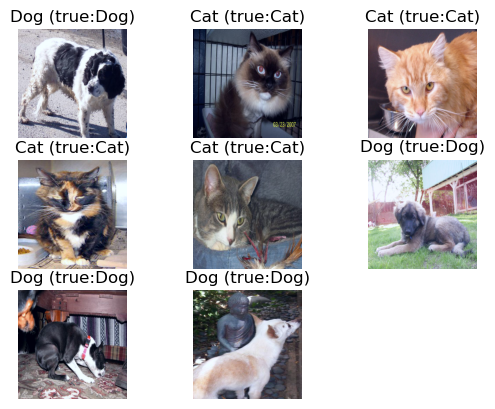

In [57]:
### ADD YOUR CODE HERE
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    pred = model_ft(images)
    _, predicted = torch.max(pred.data, 1);

figure = plt.figure()
num_of_images = min(batch_size, 9)

for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.title(f"{classes[predicted[index].item()]} (true:{classes[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.224  + 0.456).cpu().numpy().squeeze(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)

Plot heatmap (confusion matrix)

      Cat   Dog
Cat  2457    14
Dog    11  2518


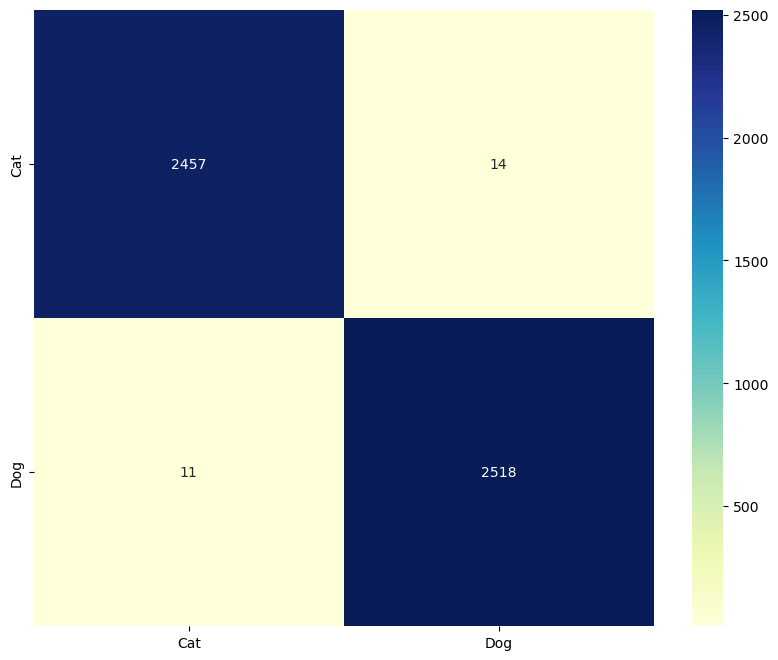

In [58]:
### ADD YOUR CODE HERE
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)

for images, labels in test_dataloader:
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label, predicted_label] += 1
print(heatmap)
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

# Saving Models
* save the structure of this class together with the model

In [59]:
### ADD YOUR CODE HERE
torch.save(model_ft, f"{model_name}_ft(assignment_3_3_22000573_JunjaeLee_epochs(5)_batch(8)_Adam).pth")